# Исследовательский анализ данных
## Изучение срезов данных
1. <a href="#0">Введение</a>
2. <a href="#1">Срезы данных и поиск авиабилетов</a>
3. <a href="#2">Срезы данных методом `query()`</a>
4. <a href="#3">Возможности `query()`</a>
5. <a href="#4">Срезы в действии</a>
6. <a href="#5">«Слишком долгая» заправка — это сколько?</a>
7. <a href="#6">Работа с датой и временем</a>
8. <a href="#7">Графики</a>
9. <a href="#8">Группировка с `pivot_table()`</a>
10. <a href="#9">Помечаем срез данных</a>
11. <a href="#10">Сохраняем результаты</a>
12. <a href="#11">Заключение</a>

<a name="0">_</a>
## Введение
Вы получили общее представление о данных — самое время исследовать их более тщательно.

**Чему вы научитесь:**
- Получать срезы данных вручную и методом query();
- Округлять время и переводить его в другие часовые пояса;
- Строить графики методом plot();
- Составлять правильные баг-репорты.

**Вам предстоит:**

- Изучить АЗС со сверхдолгими заправками;
- Определить границу, после которой можно считать заправку «слишком долгой»;
- Узнать, чем ночные заезды отличаются от дневных;
- Найти аномально быстрые заправки.


**Постановка задачи:**

Погрузитесь в детали: найдите аномально быстрые и сверхдолгие заправки. Узнайте, для каких АЗС они характерны.

<a name="1">_</a>
## Срезы данных и поиск авиабилетов
Вы уже знаете, как получить общее представление о данных. Пора научиться разбираться в деталях. Откуда взялись короткие заезды на АЗС? А очень долгие? Это характерно для одной АЗС или всех? Отличаются ли чем-то АЗС со сверхдолгими заправками от других?

Чтобы ответить на эти вопросы, нужны не все данные, а лишь их часть, или срез данных. Рассмотрим работу срезов на примере покупки авиабилетов.

Об отдыхе мечтают все, даже аналитики.

Театр начинается с вешалки, а отпуск — с поиска авиабилетов. Сделаем это, как аналитики.

Вот датафрейм с информацией об авиабилетах. Указаны пункт вылета ('From') и прилёта ('To'), наличие багажа ('Has_luggage'), прямой ли рейс ('Is_Direct'), цена билета туда-обратно ('Price'), дата вылета ('Date_From') и прилёта ('Date_To'), название авиалиний ('Airline'), время в пути в минутах туда ('Travel_time_from') и обратно ('Travel_time_to').

In [6]:
import pandas as pd
travels = pd.DataFrame(
    {
        'From': [
            'Moscow',
            'Moscow',
            'St. Petersburg',
            'St. Petersburg',
            'St. Petersburg',
        ],
        'To': ['Rome', 'Rome', 'Rome', 'Barcelona', 'Barcelona'],
        'Is_Direct': [False, True, False, False, True],
        'Has_luggage': [True, False, False, True, False],
        'Price': [21032, 19250, 19301, 20168, 31425],
        'Date_From': [
            '01.07.19',
            '01.07.19',
            '04.07.2019',
            '03.07.2019',
            '05.07.2019',
        ],
        'Date_To': [
            '07.07.19',
            '07.07.19',
            '10.07.2019',
            '09.07.2019',
            '11.07.2019',
        ],
        'Airline': ['Belavia', 'S7', 'Finnair', 'Swiss', 'Rossiya'],
        'Travel_time_from': [995, 230, 605, 365, 255],
        'Travel_time_to': [350, 225, 720, 355, 250],
    }
)
travels

,From,To,Is_Direct,Has_luggage,Price,Date_From,Date_To,Airline,Travel_time_from,Travel_time_to
0,Moscow,Rome,False,True,21032,01.07.19,07.07.19,Belavia,995,350
1,Moscow,Rome,True,False,19250,01.07.19,07.07.19,S7,230,225
2,St. Petersburg,Rome,False,False,19301,04.07.2019,10.07.2019,Finnair,605,720
3,St. Petersburg,Barcelona,False,True,20168,03.07.2019,09.07.2019,Swiss,365,355
4,St. Petersburg,Barcelona,True,False,31425,05.07.2019,11.07.2019,Rossiya,255,250


Изучим только рейсы из Москвы. Нужен код, работающий как фильтр. Он берёт в будущий срез строки со значением 'Moscow' в столбце 'From', а не интересные нам строки со значением 'St. Petersburg' не возьмёт.

Этим фильтром может стать булев массив, состоящий из `True` и `False`. Так, значениями `True` отметим, что хотим включить строку c `'Moscow'` в срез данных. А `False` обозначим не нужные для среза строки.

Составим булев массив и назовём его `filter_list`:

In [62]:
filter_list = [True, True, False, False, False]

Он сообщает, что последние три строки не понадобятся, а первые две надо взять. Чтобы автоматически собрать данные в срез, передадим массив как индекс датафрейма:

In [64]:
travels[filter_list]

,From,To,Is_Direct,Has_luggage,Price,Date_From,Date_To,Airline,Travel_time_from,Travel_time_to
0,Moscow,Rome,False,True,21032,01.07.19,07.07.19,Belavia,995,350.0
1,Moscow,Rome,True,False,19250,01.07.19,07.07.19,S7,230,225.0


Получилось!

Однако размечать нужные строки вручную — занятие утомительное. Построим фильтр автоматически. Сперва соберём список, где строкам с 'Moscow' соответствуют значения `True`, а остальным — `False`:

In [66]:
print(travels['From'] == 'Moscow')

0     True
1     True
2    False
3    False
4    False
Name: From, dtype: bool


Получили знакомый булев массив, уже не вручную. Осталось выбрать строки со значением `True`:

In [68]:
#print(travels[travels['From'] == 'Moscow']) # передаём булев массив как индекс датафрейма
travels[travels['From'] == 'Moscow']

,From,To,Is_Direct,Has_luggage,Price,Date_From,Date_To,Airline,Travel_time_from,Travel_time_to
0,Moscow,Rome,False,True,21032,01.07.19,07.07.19,Belavia,995,350.0
1,Moscow,Rome,True,False,19250,01.07.19,07.07.19,S7,230,225.0


Отлично! Вы узнали, как задавать условия для получения срезов. Приём одинаково эффективен для датафреймов в 5, 10, 200 и 1000000 строк. Условием создания булева массива может выступать не только равенство, но и другие операции сравнения: `!=`, `>`, `>=`, `<`, `<=`.

Бюджет на отпуск даже у аналитиков ограничен. Выведем срез данных, где цена на билет меньше 21000 рублей:

In [69]:
travels[travels['Price'] < 21000]

,From,To,Is_Direct,Has_luggage,Price,Date_From,Date_To,Airline,Travel_time_from,Travel_time_to
1,Moscow,Rome,True,False,19250,01.07.19,07.07.19,S7,230,225.0
2,St. Petersburg,Rome,False,False,19301,04.07.2019,10.07.2019,Finnair,605,720.0
3,St. Petersburg,Barcelona,True,False,20168,03.07.2019,09.07.2019,Swiss,365,355.0


Значения в столбцах можно сравнивать и с числами, и между собой. Бывает, что путь туда занимает не столько же времени, сколько путь обратно. Рассмотрим случаи, когда на дорогу назад ('Travel_time_to') уходит больше времени, чем на дорогу вперёд ('Travel_time_from'):

In [70]:
travels[travels['Travel_time_to'] > travels['Travel_time_from']]  

,From,To,Is_Direct,Has_luggage,Price,Date_From,Date_To,Airline,Travel_time_from,Travel_time_to
2,St. Petersburg,Rome,False,False,19301,04.07.2019,10.07.2019,Finnair,605,720.0


Чтобы проверить наличие конкретных значений в столбце, вызовем метод `isin()`. Посмотрим, какие рейсы вылетают после 3 июля 2019:

In [71]:
travels[travels['Date_From'].isin(('04.07.2019', '05.07.2019'))] # находим элементы столбца Date_From, равные 4 или 5 июля 

,From,To,Is_Direct,Has_luggage,Price,Date_From,Date_To,Airline,Travel_time_from,Travel_time_to
2,St. Petersburg,Rome,False,False,19301,04.07.2019,10.07.2019,Finnair,605,720.0
4,St. Petersburg,Barcelona,False,True,31425,05.07.2019,11.07.2019,Rossiya,255,250.0


Иногда нужно получить выборку, соответствующую сразу нескольким условиям — для этого существуют логические операции. Их синтаксис:


<img src="../pics/12.png" alt="python" width="600">

Оператор ~ можно использовать и для проверки одного условия, например, чтобы отобрать билеты без багажа: ~(df['Has_luggage']).

Обратите внимание, что здесь условия указывают в **скобках** — в отличие от синтаксиса логических операций с `or`, `and` или `not`.

### Задача 1/3
Выберите дешёвые авиабилеты — те у которых цена меньше максимальной в полтора раза или ещё ниже.

Выведите на экран полученную выборку.
>Сравните столбец `'Price'`, умноженный на 1,5, с максимальным значением столбца `'Price'`. Полученный булев массив передайте в качестве индекса исходному датафрейму.

In [72]:
import pandas as pd

df = pd.DataFrame(
    {
        'From': [
            'Moscow',
            'Moscow',
            'St. Petersburg',
            'St. Petersburg',
            'St. Petersburg',
        ],
        'To': ['Rome', 'Rome', 'Rome', 'Barcelona', 'Barcelona'],
        'Is_Direct': [False, True, False, False, True],
        'Has_luggage': [True, False, False, True, False],
        'Price': [21032, 19250, 19301, 20168, 31425],
        'Date_From': [
            '01.07.19',
            '01.07.19',
            '04.07.2019',
            '03.07.2019',
            '05.07.2019',
        ],
        'Date_To': [
            '07.07.19',
            '07.07.19',
            '10.07.2019',
            '09.07.2019',
            '11.07.2019',
        ],
        'Airline': ['Belavia', 'S7', 'Finnair', 'Swiss', 'Rossiya'],
        'Travel_time_from': [995, 230, 605, 365, 255],
        'Travel_time_to': [350, 225, 720, 355, 250],
    }
)


#print(df[(df['Price']*1.5) < (df['Price'].max())])
df[(df['Price']*1.5) < (df['Price'].max())]

,From,To,Is_Direct,Has_luggage,Price,Date_From,Date_To,Airline,Travel_time_from,Travel_time_to
1,Moscow,Rome,True,False,19250,01.07.19,07.07.19,S7,230,225
2,St. Petersburg,Rome,False,False,19301,04.07.2019,10.07.2019,Finnair,605,720
3,St. Petersburg,Barcelona,False,True,20168,03.07.2019,09.07.2019,Swiss,365,355


### Задача 2/3
Выберите строки, где значения столбца `'Travel_time_from'` больше или равно 365, или значения `'Travel_time_to'` меньше 250. Результат выведите на экран.
>Составьте условия (каждое в скобках) для столбцов, применив операторы `>=` и `<`. Логическое ИЛИ задаёт оператор `|`. Получившуюся конструкцию передайте датафрейму как индекс.

In [73]:
df[(df['Travel_time_from'] >= 365) | (df['Travel_time_to'] <250)]

,From,To,Is_Direct,Has_luggage,Price,Date_From,Date_To,Airline,Travel_time_from,Travel_time_to
0,Moscow,Rome,False,True,21032,01.07.19,07.07.19,Belavia,995,350
1,Moscow,Rome,True,False,19250,01.07.19,07.07.19,S7,230,225
2,St. Petersburg,Rome,False,False,19301,04.07.2019,10.07.2019,Finnair,605,720
3,St. Petersburg,Barcelona,False,True,20168,03.07.2019,09.07.2019,Swiss,365,355


### Задача 3/3
Выберите строки, где:
- Полёт с пересадкой;
- Возвращение до 8 июля (ни 9, ни 10, ни 11 июля).

Результат выведите на экран.
>Составьте два условия для каждого столбца отдельно. Для столбца 'Is_Direct' укажите оператор `==`. Для столбца 'Date_To' укажите оператор `~`, применённый к методу `isin(('09.07.2019', '10.07.2019', '11.07.2019'))`. Каждое из условий укажите в скобках, а между ними поставьте оператор `&`. Получившуюся конструкцию передайте датафрейму в качестве индекса.

In [75]:
print(df[(df['Is_Direct'] == False) & ~(df['Date_To'].isin(('09.07.2019','10.07.2019','11.07.2019')))])

     From    To  Is_Direct  Has_luggage  Price Date_From   Date_To  Airline  \
0  Moscow  Rome      False         True  21032  01.07.19  07.07.19  Belavia   

   Travel_time_from  Travel_time_to  
0               995             350  


In [7]:
# так красивее и нагляднее
df[(df['Is_Direct'] == False) & ~(df['Date_To'].isin(('09.07.2019','10.07.2019','11.07.2019')))]

,From,To,Is_Direct,Has_luggage,Price,Date_From,Date_To,Airline,Travel_time_from,Travel_time_to
0,Moscow,Rome,False,True,21032,01.07.19,07.07.19,Belavia,995,350


<a name="2">_</a>
## Срезы данных методом `query()`
В прошлом уроке вы делали срезы в 2 шага:
- Получали булев массив, соответствующий условиям;
- Делали срез по нему.

Это гибкий инструмент получения срезов и владеть им полезно. Однако существует и более простой способ — метод `query()` (англ. «запрос»).

Необходимое условие для среза записывается в строке, которую передают как аргумент методу `query()`. А его применяют к датафрейму. В результате получаем нужный срез.

In [76]:
import pandas as pd

df = pd.DataFrame(
    {
        'From': [
            'Moscow',
            'Moscow',
            'St. Petersburg',
            'St. Petersburg',
            'St. Petersburg',
        ],
        'To': ['Rome', 'Rome', 'Rome', 'Barcelona', 'Barcelona'],
        'Is_Direct': [False, True, False, False, True],
        'Has_luggage': [True, False, False, True, False],
        'Price': [21032, 19250, 19301, 20168, 31425],
        'Date_From': [
            '01.07.19',
            '01.07.19',
            '04.07.2019',
            '03.07.2019',
            '05.07.2019',
        ],
        'Date_To': [
            '07.07.19',
            '07.07.19',
            '10.07.2019',
            '09.07.2019',
            '11.07.2019',
        ],
        'Airline': ['Belavia', 'S7', 'Finnair', 'Swiss', 'Rossiya'],
        'Travel_time_from': [995, 230, 605, 365, 255],
        'Travel_time_to': [350, 225, 720, 355, 250],
    }
)
#print(df.query('To == "Barcelona"'))
df.query('To == "Barcelona"')

,From,To,Is_Direct,Has_luggage,Price,Date_From,Date_To,Airline,Travel_time_from,Travel_time_to
3,St. Petersburg,Barcelona,False,True,20168,03.07.2019,09.07.2019,Swiss,365,355
4,St. Petersburg,Barcelona,True,False,31425,05.07.2019,11.07.2019,Rossiya,255,250


Условия, указанные в параметре `query()`:
- поддерживают разные операции сравнения: `!=`, `>`, `>=`, `<`, `<=`
- проверяют, входят ли конкретные значения в список, конструкцией: `Date_To in ("07.07.19", "09.07.2019")`. Если нужно узнать, нет ли в списке определённых значений, пишут так: `Date_To not in ("07.07.19", "09.07.2019")`.
- работают с логическими операторами в привычном виде, где «или» — `or` , «и» — `and`, «не» — `not`. Указывать условия в скобках необязательно. Без скобок операции выполняются в следующем порядке: сначала `not`, потом `and` и, наконец, `or`.

Обратите внимание, что значение "Barcelona" в коде задачи заключено в двойные кавычки. Это нужно, чтобы различать одинарные кавычки, оформляющие строку, и кавычки для элемента "Barcelona".

Условия для среза данных можно объединять. Например, чтобы отыскать прямые рейсы или билеты с включённым в стоимость багажом — мало кому нравится летать со множеством пересадок, да ещё и без вещей.


In [8]:
print(df.query('Is_Direct == True or Has_luggage == True'))

             From         To  Is_Direct  Has_luggage  Price   Date_From  \
0          Moscow       Rome      False         True  21032    01.07.19   
1          Moscow       Rome       True        False  19250    01.07.19   
3  St. Petersburg  Barcelona      False         True  20168  03.07.2019   
4  St. Petersburg  Barcelona       True        False  31425  05.07.2019   

      Date_To  Airline  Travel_time_from  Travel_time_to  
0    07.07.19  Belavia               995             350  
1    07.07.19       S7               230             225  
3  09.07.2019    Swiss               365             355  
4  11.07.2019  Rossiya               255             250  


In [77]:
df.query('Is_Direct == True or Has_luggage == True')

,From,To,Is_Direct,Has_luggage,Price,Date_From,Date_To,Airline,Travel_time_from,Travel_time_to
0,Moscow,Rome,False,True,21032,01.07.19,07.07.19,Belavia,995,350
1,Moscow,Rome,True,False,19250,01.07.19,07.07.19,S7,230,225
3,St. Petersburg,Barcelona,False,True,20168,03.07.2019,09.07.2019,Swiss,365,355
4,St. Petersburg,Barcelona,True,False,31425,05.07.2019,11.07.2019,Rossiya,255,250


Строки с какими индексами не будут выбраны в результате выполнения этого кода?

`print(df.query('Is_Direct == True or Has_luggage == True'))`
- 0
- 1
- 2
- 3
- 4

(2) Верно! Все дороги ведут в Рим, но перелёт из Санкт-Петербурга с пересадкой и без багажа — не самая приятная из них.

А как насчёт слетать куда-нибудь вместе с командой Практикума? Правда, есть ограничение: вылететь мы сможем только из Москвы. Добавьте в `query()` новое условие. Порядок выполнения трёх и более условий можно регулировать скобками.

Как должен выглядеть код, чтобы в срез данных попали только рейсы с вылетом из Москвы, в которых или нет пересадок, или в стоимость включён багаж?
- `df.query('Is_Direct == True or Has_luggage == True and From == "Moscow"')`
- `df.query('From == "Moscow" or Is_Direct == True or Has_luggage == True')`
- `df.query('(Is_Direct == True or Has_luggage == True) and To == "Moscow"')`
- `df.query('From == "Moscow" and (Is_Direct == True or Has_luggage == True)')`

(4) Ура, выбираем рейс и полетели! Хотя подождите. Какие полёты? Столько курсов ещё впереди, столько проектов... Нет-нет, только после вашего выпускного.

<a name="3">_</a>
## Возможности `query()`

Кроме объединения условий, в `query()` можно проводить математические операции:

In [78]:
# время в пути оттуда меньше чем двойное время в пути туда
df.query('Travel_time_from < 2 * Travel_time_to ')

,From,To,Is_Direct,Has_luggage,Price,Date_From,Date_To,Airline,Travel_time_from,Travel_time_to
1,Moscow,Rome,True,False,19250,01.07.19,07.07.19,S7,230,225
2,St. Petersburg,Rome,False,False,19301,04.07.2019,10.07.2019,Finnair,605,720
3,St. Petersburg,Barcelona,False,True,20168,03.07.2019,09.07.2019,Swiss,365,355
4,St. Petersburg,Barcelona,True,False,31425,05.07.2019,11.07.2019,Rossiya,255,250


И даже вызывать методы:

In [79]:
# время в пути оттуда меньше чем среднее время в пути туда
df.query('Travel_time_from < Travel_time_to.mean()')

,From,To,Is_Direct,Has_luggage,Price,Date_From,Date_To,Airline,Travel_time_from,Travel_time_to
1,Moscow,Rome,True,False,19250,01.07.19,07.07.19,S7,230,225
3,St. Petersburg,Barcelona,False,True,20168,03.07.2019,09.07.2019,Swiss,365,355
4,St. Petersburg,Barcelona,True,False,31425,05.07.2019,11.07.2019,Rossiya,255,250


Ещё в `query()` можно включать внешние переменные (не из датафрейма). Когда упоминаете такую переменную, помечайте её знаком `@`:


In [80]:
# внешняя переменная maximum_price
maximum_price = 20000
df.query('Price <= @maximum_price')

,From,To,Is_Direct,Has_luggage,Price,Date_From,Date_To,Airline,Travel_time_from,Travel_time_to
1,Moscow,Rome,True,False,19250,01.07.19,07.07.19,S7,230,225
2,St. Petersburg,Rome,False,False,19301,04.07.2019,10.07.2019,Finnair,605,720


### Задача 1/2
Выберите строки, где: `Has_luggage` равно False и `Airline` не равно ни `S7`, ни `Rossiya`. Напечатайте полученную выборку на экране.
>Запишите условия: Has_luggage равно `False`, Airline не в списке ("S7", "Rossiya") (конструкция `not in`). Между ними поставьте `and`. Передайте получившуюся строку в `query()`.

In [81]:
# впишите условие создания нужной выборки
#print(df.query('Has_luggage == False and (Airline not in "S7" and Airline not in "Rossiya")')) 
df.query('Has_luggage == False and (Airline not in "S7" and Airline not in "Rossiya")')

,From,To,Is_Direct,Has_luggage,Price,Date_From,Date_To,Airline,Travel_time_from,Travel_time_to
2,St. Petersburg,Rome,False,False,19301,04.07.2019,10.07.2019,Finnair,605,720


In [82]:
df.query('Has_luggage == False and (Airline not in "S7" and Airline not in "Rossiya")')

,From,To,Is_Direct,Has_luggage,Price,Date_From,Date_To,Airline,Travel_time_from,Travel_time_to
2,St. Petersburg,Rome,False,False,19301,04.07.2019,10.07.2019,Finnair,605,720


Записать запрос в `query()` легко: просто проговорите условие, превратите его в строку, "обнимите" скобками и передайте методу `query()`.

### Задача 2/2
Выберите строки, где Airline равно "Belavia", "S7" или "Rossiya", при этом 'Travel_time_from' меньше переменной под названием `max_time`. Напечатайте полученную выборку на экране.
>Составьте условие, проверяющее, есть ли "Belavia", "S7" или "Rossiya" в 'Airline': примените `in`, двойные кавычки для элементов и скобки для всего списка. В условии для 'Travel_time_from' обратитесь к внешней переменной с символом `@`. Сложите условия оператором `and`, превратите в строку и передайте как параметр методу `query()`.

In [32]:
max_time = 300
print(df.query('(Airline == "Belavia" or Airline == "S7" or Airline == "Rossiya") and Travel_time_from < @max_time'))

             From         To  Is_Direct  Has_luggage  Price   Date_From  \
1          Moscow       Rome       True        False  19250    01.07.19   
4  St. Petersburg  Barcelona       True        False  31425  05.07.2019   

      Date_To  Airline  Travel_time_from  Travel_time_to  
1    07.07.19       S7               230             225  
4  11.07.2019  Rossiya               255             250  


In [83]:
max_time = 300
df.query('(Airline == "Belavia" or Airline == "S7" or Airline == "Rossiya") and Travel_time_from < @max_time')

,From,To,Is_Direct,Has_luggage,Price,Date_From,Date_To,Airline,Travel_time_from,Travel_time_to
1,Moscow,Rome,True,False,19250,01.07.19,07.07.19,S7,230,225
4,St. Petersburg,Barcelona,True,False,31425,05.07.2019,11.07.2019,Rossiya,255,250


<a name="4">_</a>
## Срезы в действии
Наконец-то вы готовы строить срезы на практике.

Вспомним, как выглядела диаграмма размаха времени заезда на АЗС:

`data.boxplot();`
![boxplot](https://pictures.s3.yandex.net/resources/png_1562496190)

Есть несколько заездов со временем около 30 000 секунд (это около 8 часов). Крайне маловероятно, что водители заправляются так долго. Они повстречали свою любовь или случайно вырвали заправочный пистолет? А может, всё одновременно?

У вас есть всё необходимое, чтобы с этим разобраться.

Чтобы построить графики, обращаются к библиотеке `matplotlib` (от англ. mathematical plotting library, «библиотека математических построений»). Точнее к её модулю — `pyplot`:

In [84]:
import matplotlib.pyplot as plt

Для простейших графиков импортировать её не обязательно. Однако вызов библиотеки может помочь, когда вывод графиков нужно разделить. 

После команды вывода графика вызывают метод `show()`. Он позволяет посмотреть, как отличаются гистограммы с разным числом корзин:

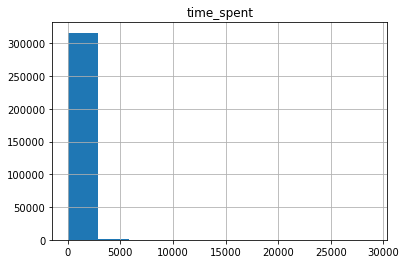

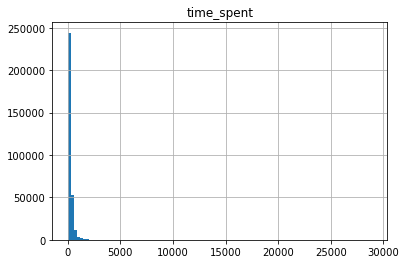

In [85]:
import matplotlib.pyplot as plt
    
data.hist(bins=10)
plt.show()
data.hist(bins=100)
plt.show()

### Задача 1/3
Узнайте, на каких АЗС водители проводят больше всего времени. Выведите топ-10 строк с самой долгой заправкой.
>Отсортируйте data по убыванию значений time_spent методом `sort_values` с параметром `ascending=False`. Затем выведите первые 10 строк методом `head(10)`. Результат выведите на экран.

In [86]:
import pandas as pd

data = pd.read_csv('../datasets/visits.csv', sep='\t')
#print(data.sort_values(by = 'time_spent', ascending = False).head(10))
data.sort_values(by = 'time_spent', ascending = False).head(10)

,date_time,id,time_spent,name
114797,20180402T055708,3c1e4c52,28925.0,Василек
27147,20180406T080254,4b5f2af5,28519.0,Немезия
60547,20180408T000002,cf1ba8a5,28292.0,Василек
19042,20180408T204208,5410e876,23696.0,Василек
118597,20180408T165020,3c1e4c52,21184.0,Василек
118058,20180402T111333,3c1e4c52,20359.0,Василек
114406,20180408T083722,3c1e4c52,19886.0,Василек
132164,20180405T160745,627ea5e3,19445.0,Левкой
281360,20180406T180459,d0c0928d,18614.0,Пион
165326,20180402T230204,3af3bb71,18569.0,Агератум


В столбце 'id' разные значения, значит долго заправляются не на одной АЗС. К тому же в списке присутствуют АЗС из разных сетей.

Выделяется `id == '3c1e4c52'`, он встречается несколько раз. Изучим эту АЗС детальнее.

### Задача 2/3

Сохраните срез данных с `id == "3c1e4c52"` в переменной `sample` (англ. «выборка, проба»). Выведите количество заездов на эту АЗС.
>Примените к датафрейму метод `query()`: в строке с условием выберите только заезды на АЗС, у которых `id == "3c1e4c52"`. Полученный срез сохраните в переменной `sample`.
Вызовом функции `len()` узнайте количество строк в срезе `sample`, результат выведите на экран.

In [9]:
import pandas as pd

data = pd.read_csv('../datasets/visits.csv', sep='\t')
sample = data.query('id == "3c1e4c52"')
print(len(sample))

5814


In [ ]:
Столько раз заезжали на АЗС `3c1e4c52`

### Задача 3/3
Посмотрим, как они распределены, отличаются ли от остальных данных. Вспомните, как выглядела гистограмма по всему набору данных.

Постройте гистограмму времён заезда на все АЗС. И аналогичную гистограмму для выбранной АЗС (мы уже сохранили данные в переменную `sample`). Для обеих гистограмм задайте диапазон 0-1500 секунд и 100 корзин.
>Возьмите данные из `sample`, примените метод `hist()` с параметрами `"time_spent"` (название колонки), `bins` и `range`.

Чтобы вывести гистограммы на разных графиках, вызовите метод `plt.show()`.

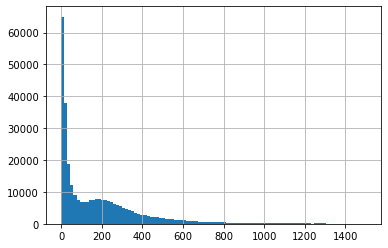

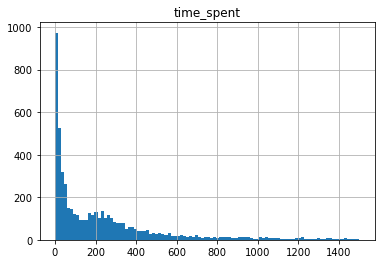

In [88]:
import matplotlib.pyplot as plt

sample = data.query('id == "3c1e4c52"')
# гистограмма времён заезда на все АЗС
data['time_spent'].hist(bins = 100, range = (0, 1500))
# гистограмма для выбранной АЗС
sample.hist('time_spent', bins=100, range = (0, 1500))
plt.show()

Гистограммы среза sample и всего набора данных внешне похожи, имеют по два пика: около нулевого времени проезда и около 200 секунд. Только гистограмма sample не такая гладкая, на ней заметны одиночные хаотичные всплески (шумы). 

Общее правило: **чем данных меньше, тем шумнее гистограмма**.

<a name="5">_</a>
## «Слишком долгая» заправка — это сколько?

Нетипично долгие заезды признаем выбросами и отбросим. Почему так можно?

Во-первых, их немного. Во-вторых, скорее всего, такие заезды — не заправки. Например, водитель мог отдыхать, есть или заниматься чем-то ещё. Раз это не заправки в чистом виде, значит в рамках нашего исследования такие заезды не интересны.

Как определить, что заправка «слишком долгая»? Где провести границу между заправкой автомобиля и прочими занятиями на АЗС?
Обратимся к гистограмме:
![gist](https://pictures.s3.yandex.net/resources/_19_1562610488.png)
Заправки продолжительностью 600 секунд — уже редки. Дольше 800 секунд почти не заправляются. А на участке более 1300 секунд гистограмма сливается с нулём (это не значит, что там ровно 0, но таких заправок единицы).

Примем верхнюю границу в 1000 секунд. Это число кажется разумным: дольше заправляются редко. Отбросив значения больше 1000, мы не потеряем много данных. Да и вряд ли водители тратят на заправку больше 1000 секунд (16 минут).

Решено. Продолжаем работать с наблюдениями, удовлетворяющими условию: `data.query('time_spent < 1000')`

<a name="6">_</a>
## Работа с датой и временем
Мы посчитали подозрительно долгие заправки выбросами. Но что делать с чрезвычайно короткими заправками? Изучим их подробнее. Узнаем, связана ли их продолжительность со временем заезда на АЗС.


In [89]:
data.head()

,date_time,id,time_spent,name
0,20180406T165358,76144fb2,98.0,Василек
1,20180404T173913,76144fb2,15.0,Василек
2,20180403T172824,76144fb2,220.0,Василек
3,20180407T070441,76144fb2,19.0,Василек
4,20180404T132049,76144fb2,14.0,Василек


В столбце `'date_time'` дата и время заезда. Из описания данных известно, что время заезда указали в часовом поясе UTC+0, в формате ISO. Значит, сначала слитно идут год, месяц, день; затем буквенный разделитель даты и времени T; затем часы, минуты и секунды — снова слитно.

В курсе по предобработке вы познакомились с методом `to_datetime()`, который переводит строки в даты. Напомним, что в аргументе `format` метода `to_datetime()` указывают специальные обозначения, порядок которых соответствует порядку чисел в строке с датой:

- `%d` — день месяца (от 01 до 31)
- `%m` — номер месяца (от 01 до 12)
- `%Y` — четырёхзначный номер года (например, 2019)
- `Z` или `T` — стандартный разделитель даты и времени
- `%H` — номер часа в 24-часовом формате
- `%I` — номер часа в 12-часовом формате
- `%M` — минуты (от 00 до 59)
- `%S` — секунды (от 00 до 59)
При выводе значений формата datetime на экран Python автоматически разделяет их символами - и :, чтобы человеку было проще воспринимать данные.

Пора научиться:
- Округлять даты;
- Добывать отдельные компоненты из дат, например, день недели;
- «Сдвигать» даты в другие часовые пояса.

О том, что операции предстоит выполнять именно с датами, аналитик сообщает Pandas отдельно, через атрибут `dt` (от англ. date time). Атрибут `dt` указывает, что тип данных, к которым будут применены методы, — `datetime`. А значит, Pandas не примет их за строки или числа.
Чтобы округлить время, применяют метод `dt.round()` (англ. round, «округлять»). В качестве параметра ему передают строку с шагом округления в часах, днях, минутах или секундах:
- `'D'` — day (от англ. «день»)
- `'H'` — hour (от англ. «час»)
- `'min'` или `'T'` — minute (от англ. «минута»)
- `'S'` — second (от англ. «секунда»)

Чаще всего округляют с шагом в один час:


In [90]:
import pandas as pd

df = pd.DataFrame({'time': ['11-03-01 17:34']})
# здесь формат даты отличается от формата в таблице с данными АЗС
df['time'] = pd.to_datetime(df['time'], format='%y-%m-%d %H:%M')
df['time_rounded'] = df['time'].dt.round(
    '1H'
)  # округляем до ближайшего значения с шагом в один час
print(df['time_rounded'])

0   2011-03-01 18:00:00
Name: time_rounded, dtype: datetime64[ns]


`dt.round()` округляет до ближайшего значения — не всегда получается в бóльшую сторону. Четверть шестого после округления методом `dt.round()` станет пятью часами:

In [91]:
import pandas as pd

df = pd.DataFrame({'time': ['11-03-01 17:15']})
df['time'] = pd.to_datetime(df['time'], format='%y-%m-%d %H:%M')
df['time_rounded'] = df['time'].dt.round(
    '1H'
)  # округляем до ближайшего значения с шагом в один час
print(df['time_rounded'])

0   2011-03-01 17:00:00
Name: time_rounded, dtype: datetime64[ns]


Чтобы быть уверенными в том, что время будет округлено к бóльшему значению, обращаются к методу `dt.ceil()` (от англ. ceiling — «потолок»). К меньшему значению, «вниз», округляют методом `dt.floor()` (англ. floor, «пол»).

In [92]:
import pandas as pd

df = pd.DataFrame({'time': ['11-03-01 17:15']})
df['time'] = pd.to_datetime(df['time'], format='%y-%m-%d %H:%M')
df['ceil'] = df['time'].dt.ceil('1H') # округляем к потолку
df['floor'] = df['time'].dt.floor('1H') # округляем к полу
print('Время, округлённое вверх', df['ceil'])
print('Время, округлённое вниз', df['floor'])

Время, округлённое вверх 0   2011-03-01 18:00:00
Name: ceil, dtype: datetime64[ns]
Время, округлённое вниз 0   2011-03-01 17:00:00
Name: floor, dtype: datetime64[ns]


Номер дня в неделе находят методом `dt.weekday` (англ. weekday, «будний день»). Понедельник — день под номером 0, а воскресенье — шестой день.

In [93]:
import pandas as pd 

df = pd.DataFrame({'time': ['11-03-07 17:15', '11-04-02 17:15']}) # пн и сб
df['time'] = pd.to_datetime(df['time'], format='%y-%m-%d %H:%M')
df['weekday'] = df['time'].dt.weekday
print(df['weekday'])

0    0
1    5
Name: weekday, dtype: int64


Иногда нужно переводить время в другой часовой пояс. За временные сдвиги отвечает `pd.Timedelta()` (от англ. time delta — «дельта времени, перепад во времени»). Количество часов передают в параметре: `(hours=10)`.
Прибавим 9 часов к московскому времени и узнаем, который час был в Петропавловске-Камчатском, когда в Москве происходили события датафрейма:

In [57]:
import pandas as pd

df = pd.DataFrame({'time': ['11-03-07 17:15', '11-05-02 10:20']})
df['moscow_time'] = pd.to_datetime(df['time'], format='%y-%m-%d %H:%M')
df['petropavlovsk-kamchatsky_time'] = df['moscow_time'] + pd.Timedelta(hours=9)
print(df['petropavlovsk-kamchatsky_time'])

0   2011-03-08 02:15:00
1   2011-05-02 19:20:00
Name: petropavlovsk-kamchatsky_time, dtype: datetime64[ns]


Можно и наоборот: отнимать время, указав в параметре отрицательное количество часов.

### Задача 1/3
Переведите значения в столбце 'date_time' в формат даты.

В аргументе `format` метода `to_datetime()` передайте строку со значениями года, месяца, дня и времени, чтобы получить запись вида: 2018-04-06T16:53:58. Результат сохраните в столбце `'date_time'`.

Первые 5 строк таблицы data выведите на экран.
>Примените метод `to_datetime()` к столбцу `'date_time'`, указав значением аргумента `format` строку вида: `'%Y%m%dT%H%M%S'`. 

In [97]:
import pandas as pd

data = pd.read_csv('datasets/visits.csv', sep='\t')

In [98]:
df = pd.DataFrame({'time': ['11-03-01 17:34']})
# переводим значения в столбце в формат даты
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y%m%dT%H%M%S')
#print(data.head())
data.head()

,date_time,id,time_spent,name
0,2018-04-06 16:53:58,76144fb2,98.0,Василек
1,2018-04-04 17:39:13,76144fb2,15.0,Василек
2,2018-04-03 17:28:24,76144fb2,220.0,Василек
3,2018-04-07 07:04:41,76144fb2,19.0,Василек
4,2018-04-04 13:20:49,76144fb2,14.0,Василек


даты стали удобочитаемыми

### Задача 2/3
Напомним, что в датафрейме записано время UTC. Московское рассчитывают как UTC + 3 часа.
Создайте столбец data`['local_time']` и сохраните в нём сдвинутую на +3 часа дату и время из столбца `data['date_time']`. Напечатайте первые 5 строк таблицы `data`.
>Передайте в параметре `Timedelta` количество часов, равное 3. Первые 5 строк выведите на экран методом `head()`.

In [99]:
# в столбце local_time сохраняем дату и время из столбца date_time
# делаем поправку на 3 часа
data['local_time'] = data['date_time'] + pd.Timedelta(hours=3)
#print(data.head())
data.head()

,date_time,id,time_spent,name,local_time
0,2018-04-06 16:53:58,76144fb2,98.0,Василек,2018-04-06 19:53:58
1,2018-04-04 17:39:13,76144fb2,15.0,Василек,2018-04-04 20:39:13
2,2018-04-03 17:28:24,76144fb2,220.0,Василек,2018-04-03 20:28:24
3,2018-04-07 07:04:41,76144fb2,19.0,Василек,2018-04-07 10:04:41
4,2018-04-04 13:20:49,76144fb2,14.0,Василек,2018-04-04 16:20:49


### Задача 3/3
Создайте столбец `data['date_hour']` с московским временем заезда на АЗС, округлённым до 1 часа методом `dt.round()`. Напечатайте первые 5 строк.
>К данным столбца 'local_time' примените метод `dt.round()`, передав шаг округления в 1 час. Присвойте результат столбцу 'date_hour'.

In [101]:
# округляем до ближайшего значения с шагом в один час
data['date_hour'] = data['local_time'].dt.round('1H')
#print(data.head())
data.head()

,date_time,id,time_spent,name,local_time,date_hour
0,2018-04-06 16:53:58,76144fb2,98.0,Василек,2018-04-06 19:53:58,2018-04-06 20:00:00
1,2018-04-04 17:39:13,76144fb2,15.0,Василек,2018-04-04 20:39:13,2018-04-04 21:00:00
2,2018-04-03 17:28:24,76144fb2,220.0,Василек,2018-04-03 20:28:24,2018-04-03 20:00:00
3,2018-04-07 07:04:41,76144fb2,19.0,Василек,2018-04-07 10:04:41,2018-04-07 10:00:00
4,2018-04-04 13:20:49,76144fb2,14.0,Василек,2018-04-04 16:20:49,2018-04-04 16:00:00


Вы привели время к рабочему формату. новые столбцы local_time и date_hour пригодятся в следующем уроке.

<a name="7">_</a>
## Графики
Что делать, если данных много, а построить график хочется? Разглядывать сотни тысяч точек сложно. Значит, визуализировать нужно сгруппированные данные или срез. В этом уроке вы построите график по готовому срезу id == '3c1e4c52'. Начнём с основ.

За построение графиков в Pandas отвечает метод `plot()` (англ. «график»). Вот простой пример:

   a   b
0  2   4
1  3   9
2  4  16
3  5  25


<AxesSubplot:>

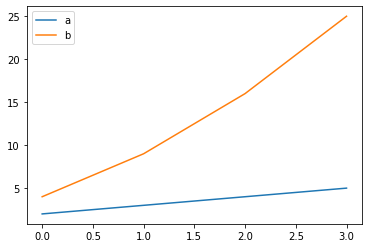

In [102]:
df = pd.DataFrame({'a': [2, 3, 4, 5], 'b': [4, 9, 16, 25]})
print(df)
df.plot()

Метод `plot()` построил графики по значениям столбцов из датафрейма. На оси абсцисс (x) расположились индексы, а на оси ординат (y) — значения столбцов.

Названия для графиков указывают строкой или переменной в параметре `title` (англ. «название»):

<AxesSubplot:title={'center':'A и B'}>

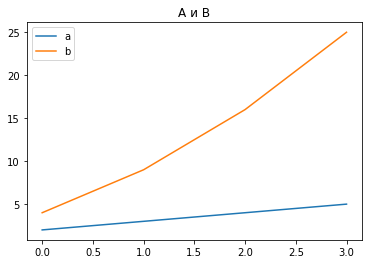

In [103]:
df.plot(title='A и B')

Элементов в таблице слишком мало, чтобы они складывались в непрерывную линию. Добавим графику точности, передадим параметр `style`, со значением 'o', чтобы отметить значения таблицы точками.

<AxesSubplot:>

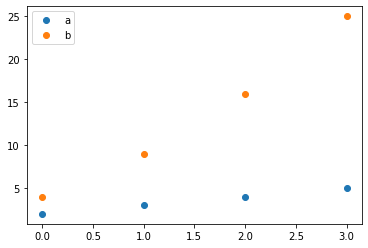

In [104]:
df.plot(style='o') # 'o' похожа на кружок или точку, запомнить легко

Можно задать и другую форму точек. Например, `style='х'` пометит точки крестиками:

<AxesSubplot:>

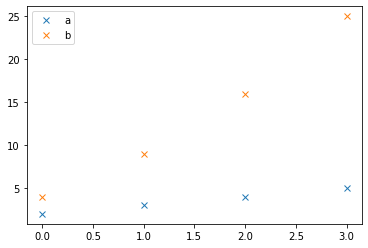

In [105]:
df.plot(style='x') # 'x' - точь-в-точь крестик

Когда нужен компромиссный вариант: и линии, и точки; передают `style='o-'`.

<AxesSubplot:>

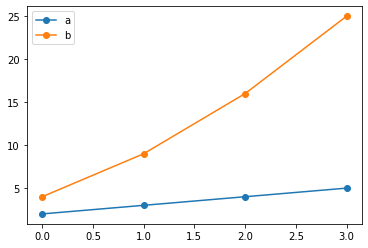

In [106]:
df.plot(style='o-') # 'o-' - кружок и линия

Напомним, что по горизонтальной оси отложены индексы. Но что, если такой способ представления не годится для анализа? Можно изменить сами индексы или передать методу `plot()` параметры осей. Так, оси абсцисс (x) присвоим значения столбца 'b', а оси ординат (y) — значения столбца 'a':

<AxesSubplot:xlabel='b'>

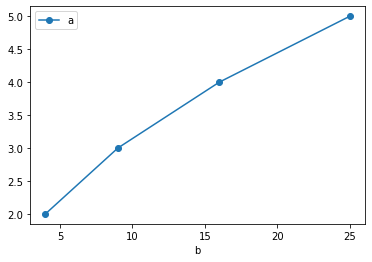

In [107]:
df.plot(x='b', y='a', style='o-')

По оси абсцисс идут значения столбца b, а по оси ординат — значения столбца a. Обратите внимание, что Pandas переименовал горизонтальную ось: теперь она — b. А в легенде (списке условных обозначений на графике) осталась только линия со значениями столбца a.

Ещё не всё идеально: точки упираются в края графика. Скорректируем границы параметрами xlim и ylim — с ними вы познакомились, когда изучали ящик с усами. Напомним, что параметрам xlim и ylim в скобках передают минимальное и максимальное значение. Ограничим ось абсцисс значениями от 0 до 30:

<AxesSubplot:xlabel='b'>

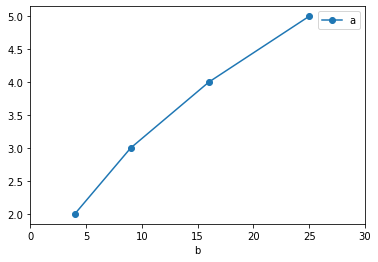

In [108]:
df.plot(x='b', y='a', style='o-', xlim=(0, 30))

Добавим линии сетки: с ними будет легче понять, какие именно значения отображены. Укажем параметр `grid` (англ. «сетка, решётка»), равный `True` (это значит, что **отображать сетку — нужно**):


<AxesSubplot:xlabel='b'>

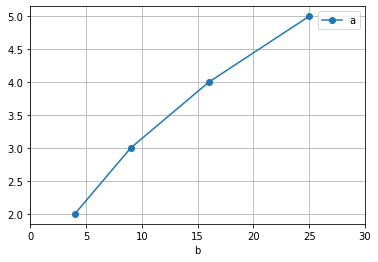

In [109]:
df.plot(x='b', y='a', style='o-', xlim=(0, 30), grid=True)

Размером графика управляют через параметр `figsize` (от англ. size of a figure — «размер фигуры»). Ширину и высоту области построения в дюймах передают параметру в скобках: `figsize = (x_size, y_size)`. Сравним графики с разными размерами:

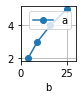

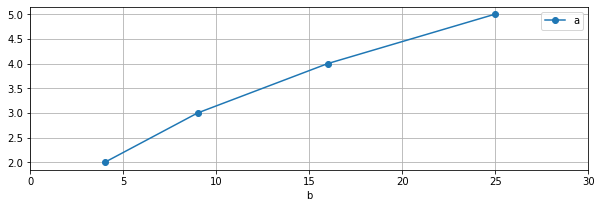

In [110]:
# строим маленький график
df.plot(x='b', y='a', style='o-', xlim=(0, 30), grid=True, figsize=(1, 1))

# строим большой график
df.plot(x='b', y='a', style='o-', xlim=(0, 30), grid=True, figsize=(10, 3));

Вот вы и знаете о построении графиков так много, что справитесь с визуальным представлением срезов данных по АЗС.

### Задача
Сделайте срез из данных по АЗС с `id == "3c1e4c52"`. Сохраните в переменной `sample`.

Постройте график зависимости продолжительности заправки от времени заезда. За основу возьмите соответствующие столбцы `'time_spent'` и `'local_time'`.

Каждый заезд должен выглядеть как отдельная точка, не соединённая линиями с другими точками. Для этого вам потребуется маркер `'o'`.
Ограничьте график значениями до 1000 секунд. Нарисуйте линии сетки. Увеличьте размер графика до 12 дюймов по горизонтали и 6 по вертикали.
>Методом `query()` получите нужный срез. Сохраните результат в `sample`. Методу `plot()` задайте параметры: `x, y, ylim, style, grid, figsize`.

<AxesSubplot:xlabel='local_time'>

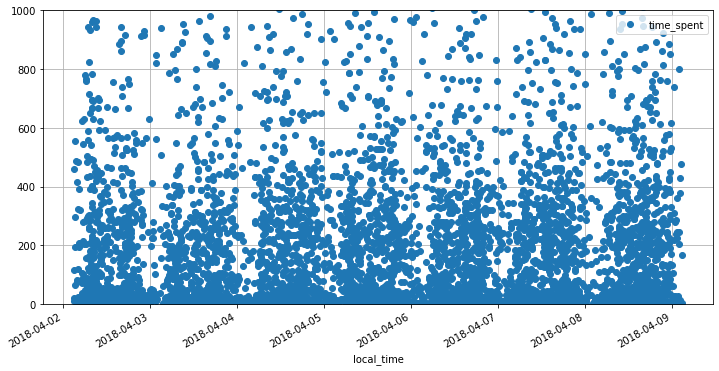

In [112]:
# прекод
import pandas as pd
data = pd.read_csv('datasets/visits.csv', sep='\t')
data['date_time'] = pd.to_datetime(
    data['date_time'], format='%Y-%m-%dT%H:%M:%S'
)
data['local_time'] = data['date_time'] + pd.Timedelta(hours=3)

# срез из данных по АЗС 3c1e4c52 - в переменной sample
sample = data.query('id == "3c1e4c52"')
# график зависимости продолжительности заправки от времени заезда
sample.plot(x='local_time', y='time_spent', style='o', ylim=(0, 1000), grid=True, figsize=(12, 6))

Все еще не наглядно

<a name="8">_</a>
## Группировка с `pivot_table()`
На графике видна структура с провалами плотности в районе ночных часов. Это кажется правдоподобным: машин и, как следствие, заправок ночью меньше.

Подозрительно коротких заездов (с продолжительностью менее 100 секунд) много в любое время суток. Хотя график строили по срезу, данных будто не стало меньше. Точки сливаются, делать по ним уверенные выводы трудно. Попробуем улучшить визуальное представление группировкой данных.

Прежде чем строить красивый график, позаботимся о красивом коде. В прошлом уроке вы сохранили срез в переменной `sample`, и к ней применили метод `plot()`:

<AxesSubplot:xlabel='local_time'>

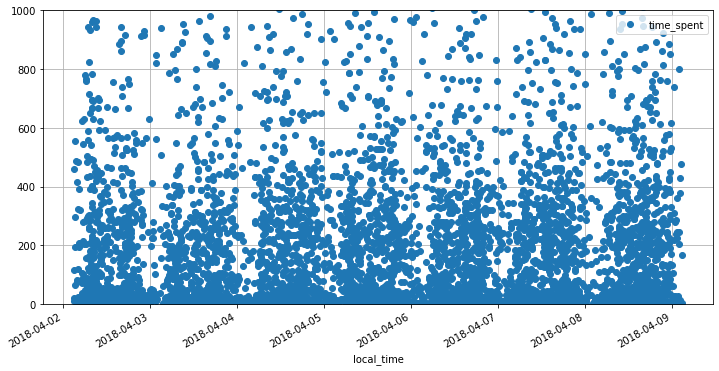

In [113]:
sample = data.query('id == "3c1e4c52"')
sample.plot(
    x='local_time',
    y='time_spent',
    ylim=(0, 1000),
    style='o',
    grid=True,
    figsize=(12, 6),
)

Такой код хорош, когда к `sample` обращаются и дальше, в будущих расчётах. А если это не так? Введение новой сущности ради построения графика путает больше, чем упрощает.

**ЭТО ИНТЕРЕСНО: БРИТВА ОККАМА**

Entia non sunt multiplicanda praeter necessitatem — «Не следует множить сущности без необходимости». Фраза раскрывает принцип, названный «Бритва Оккама» в честь философа XIII века, монаха Уильяма из английской деревушки Оккам.

Суть принципа: совершенство должно быть простым.

Если какого-то результата можно достичь с привлечением сущностей A, B и C; либо другим путём с привлечением A, B, С и D — надо выбирать первый путь.

<img src="https://pictures.s3.yandex.net/resources/britva_akkama_1562611742.jpg" alt="python" width="600"/>

Не будем множить сущности без необходимости и избавимся от промежуточных переменных. Применим метод `plot()` к результату работы `query()` безо всяких `sample`. Получится конструкция вида:

`data.query().plot()`

Передадим нужные параметры. Чтобы код было легко читать, запишем его в несколько строк. Так код выглядит яснее:

Вернёмся к данным по АЗС. На графике слишком много точек. Чтобы сделать его нагляднее, будем отмечать **не визит, а среднюю продолжительность заправки в час**. Вы уже создавали столбец 'date_hour' с округлённым временем заезда на АЗС.

Обратимся к `pivot_table()`. Добавим сводную таблицу в цепочку между `query()` и `plot()`:


<AxesSubplot:xlabel='date_hour'>

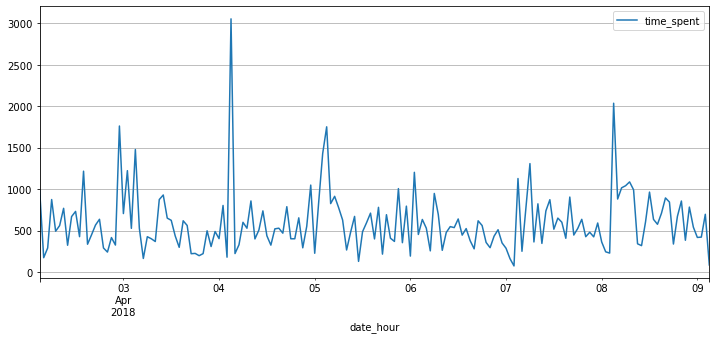

In [116]:
data['date_time'] = pd.to_datetime(
    data['date_time'], format='%Y-%m-%dT%H:%M:%S'
)
data['local_time'] = data['date_time'] + pd.Timedelta(hours=3)
data['date_hour'] = data['local_time'].dt.round('1H')
(
    data.query('id == "3c1e4c52"')
    .pivot_table(index='date_hour', values='time_spent')
    .plot(grid=True, figsize=(12, 5))
)

На графике показана средняя продолжительность заправки на АЗС под номером "3c1e4c52" за каждый час. Обратите внимание, что в среднем водители проводят на АЗС около 500 секунд. Помня о пике гистограммы в 200 секунд, нельзя не удивиться такому значению.

<img src="https://pictures.s3.yandex.net/resources/_19_1562611847.png" alt="python" width="350"/>

Есть и таинственный пик, когда среднее время заправки достигло 3000 секунд (почти час). Многовато. В прошлых уроках мы вообще отбрасывали заезды дольше 1000 секунд, ведь они не слишком похожи на правду. Добавим соответствующее условие в `query()`:

<AxesSubplot:xlabel='date_hour'>

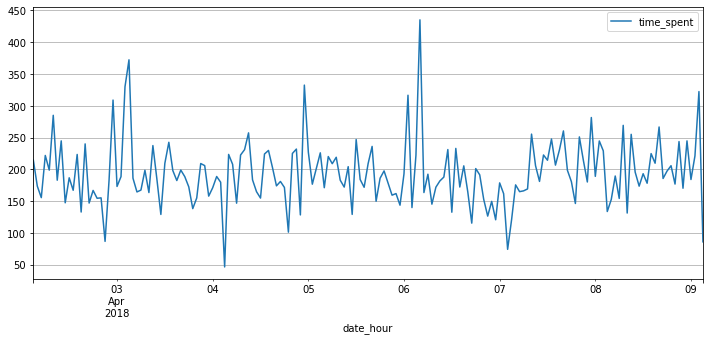

In [119]:
(
    data.query('id == "3c1e4c52" and time_spent < 1000')
    .pivot_table(index='date_hour', values='time_spent')
    .plot(grid=True, figsize=(12, 5))
)

Средняя продолжительность заправки снизилась вполовину! Вот вы и увидели, как **выбросы влияют на среднее**.

Вычислим устойчивую к выбросам **медиану**. В `pivot_table()` значением параметра `aggfunc` передадим `'median'`.

Напомним, что в `aggfunc` передают функцию, которую применяют к значениям сводной таблицы. Например, метод `'count'` посчитает число значений в группе. Если в `aggfunc` не указать ничего, отработает расчёт среднего: `'mean'`.

<AxesSubplot:xlabel='date_hour'>

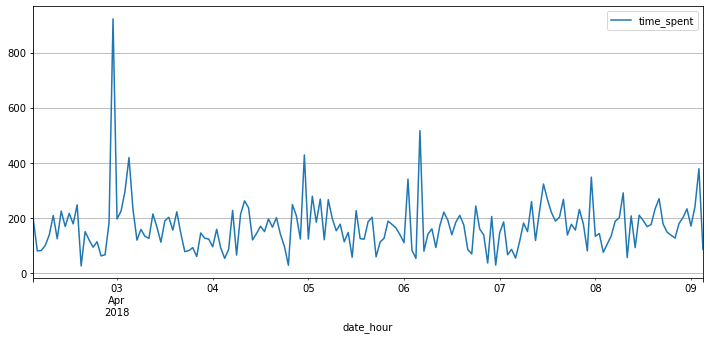

In [120]:
(
    data.query('id == "3c1e4c52"')
    .pivot_table(index='date_hour', values='time_spent', aggfunc='median')
    .plot(grid=True, figsize=(12, 5))
)

Обратите внимание, что даже без фильтра `'time_spent < 1000'` медиана дала среднюю продолжительность заправки примерно в 200 секунд. Медиана устойчива к выбросам, но всё же не безупречна: пик более 800 секунд в ночь со 2-го на 3-е апреля выглядит аномальным значением.

В целом нет никакой явной связи между продолжительностью заезда и временем дня. Это странно. На этой АЗС не бывает очередей? Или что-то не так с данными? Число заездов в течение дня точно должно меняться. Проверьте это.

### Задача
Постройте график числа заездов на АЗС с `id == "3c1e4c52"` по данным сводной таблицы с аргументами `index='date_hour'`, `values='time_spent'`. Параметру `aggfunc` установите значение `'count'`.
Добавьте на график сетку. Задайте размер `12*5` дюймов в параметре `figsize`.
>Перепишите пример кода из урока. Для вычисления количества заездов передайте `aggfunc` значение `'count'`.

<AxesSubplot:xlabel='date_hour'>

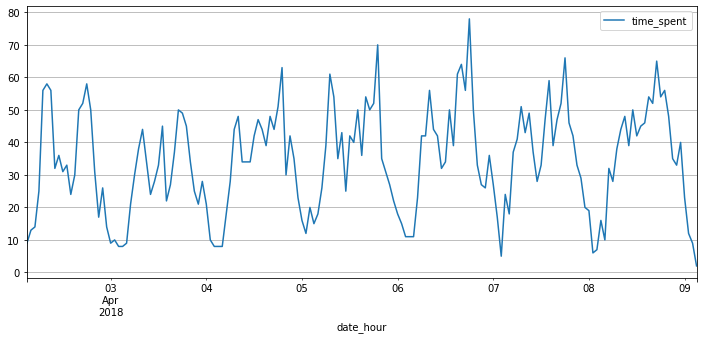

In [122]:
# прекод
data = pd.read_csv('datasets/visits.csv', sep='\t')
data['local_time'] = pd.to_datetime(
    data['date_time'], format='%Y-%m-%dT%H:%M:%S'
) + pd.Timedelta(hours=3)
data['date_hour'] = data['local_time'].dt.round('1H')

# запрос по id == "3c1e4c52"
# сводная таблица с заданными параметрами
# код графика: сетка и размер
(
    data.query('id == "3c1e4c52"')
    .pivot_table(index='date_hour', values='time_spent', aggfunc='count')
    .plot(grid=True, figsize=(12, 5))
)
# в одну строку тожее работает
# (data.query('id == "3c1e4c52"').pivot_table(index='date_hour', values='time_spent', aggfunc='count').plot(grid=True, figsize=(12, 5)))

Мы обнаружили ожидаемую закономерность. Ночью заездов на АЗС в несколько раз меньше, чем днем. Факт заезда отображен в данных правдоподобно, а вот с продолжительностью пока непонятно...

<a name="9">_</a>
## Помечаем срез данных
Продолжительность заправки около 0 секунд всё ещё выглядит необъяснимо странной. Неужели такие заезды придётся отбросить? Мы уже сделали это с подозрительно долгими заправками, признав их выбросами. Однако сверхкоротких заездов гораздо больше, чем очень долгих. Если мы от них избавимся, то наверняка сильно исказим данные.

Как много строк мы потеряем, если просто отбросим подозрительно короткие события? Посчитаем долю заездов на АЗС продолжительностью менее 60 секунд:

In [123]:
# делим количество заездов короче 60 секунд на общее число заездов
print(len(data.query('time_spent < 60')) / len(data)) 

0.42213910893586964


Таких аномально быстрых заездов у нас 42%. Очень много.

Насколько равномерно они распределены по разным АЗС? Везде около 40%? Или где-то их нет, а на каких-то АЗС много? Сгруппируем данные по АЗС и выясним, откуда взялось такое среднее.

Чтобы узнать, как получилось такое среднее, строят и изучают гистограмму.

Для каждой АЗС найдём среднее число аномально быстрых заездов. Пометим их и сгруппируем данные по АЗС. И по этим значениям уже построим гистограмму.

### Задача 1/5
Создайте столбец `data['too_fast']` (англ. too fast, «слишком быстрый»), со значениями:
- `True` — если время заезда менее 60 секунд
- `False` — если от 60 секунд

Напечатайте первые 5 строк data.
>В столбце `data['too_fast']` сохраните булев массив, где `True` будут обозначены значения столбца `data['time_spent']` меньше 60 секунд. 

In [126]:
# прекод
data = pd.read_csv('datasets/visits.csv', sep='\t')
data['local_time'] = pd.to_datetime(
    data['date_time'], format='%Y-%m-%dT%H:%M:%S'
) + pd.Timedelta(hours=3)

# столбец data['too_fast']
data['too_fast'] = data['time_spent'] < 60
#print(data.head())
data.head()

,date_time,id,time_spent,name,local_time,too_fast
0,20180406T165358,76144fb2,98.0,Василек,2018-04-06 19:53:58,False
1,20180404T173913,76144fb2,15.0,Василек,2018-04-04 20:39:13,True
2,20180403T172824,76144fb2,220.0,Василек,2018-04-03 20:28:24,False
3,20180407T070441,76144fb2,19.0,Василек,2018-04-07 10:04:41,True
4,20180404T132049,76144fb2,14.0,Василек,2018-04-04 16:20:49,True


Вот и знакомый булев массив. Кстати, вы никогда не задумывались, что получится, если рассчитать среднее арифметическое по такому массиву?

### Задача 2/5
Выведите среднее значение по столбцу 'too_fast'.
>Примените метод `mean()` к столбцу `'too_fast'`.

In [128]:
#прекод
data = pd.read_csv('datasets/visits.csv', sep='\t')
data['local_time'] = pd.to_datetime(
    data['date_time'], format='%Y-%m-%dT%H:%M:%S'
) + pd.Timedelta(hours=3)
data['too_fast'] = data['time_spent'] < 60
# среднее значение по столбцу
data['too_fast'].mean()

0.42213910893586964

Знакомые числа! 
Это же доля аномально быстрых заправок. Как так получилось?
Когда мы вовлекаем булевы переменные в арифметические операции, Pandas заменяет их соответствующими числовыми значениями (1 и 0). Получается, что 0,42 — доля единиц, или слишком быстрых заправок, среди всех зафиксированных визитов.

### Задача 3/5
Найдите долю аномально быстрых заправок для разных АЗС (т.е. разных id) — обратитесь к сводным таблицам. Создайте переменную too_fast_stat, в которой для каждого id будет доля быстрых заправок. Выведите первые 5 строк.
>Примените `pivot_table()` к таблице `data`. Передайте столбец 'id' как значение параметра index. А столбец 'too_fast' передайте параметру `values`. Получившееся значение присвойте переменной `too_fast_stat`.

In [129]:
#прекод
data = pd.read_csv('datasets/visits.csv', sep='\t')
data['local_time'] = pd.to_datetime(
    data['date_time'], format='%Y-%m-%dT%H:%M:%S'
) + pd.Timedelta(hours=3)
data['too_fast'] = data['time_spent'] < 60
# сводная таблица по id и доле быстрых заправок
too_fast_stat = data.pivot_table(index='id', values='too_fast')
#print(too_fast_stat.head())
too_fast_stat.head()

,too_fast
id,
00ca1b70,0.250000
011f7462,0.637489
015eaddd,0.726190
0178ce70,0.211538
018a83ef,0.510269


Уже по первым пяти строкам видно, что доля сверхкоротких заправок очень неоднородна: на одних АЗС они составляют по 20% всех заездов, а на других — целых 70%.

Что мы делаем, когда хотим понять, откуда взялось такое среднее? Строим гистограмму.

### Задача 4/5
Постройте гистограмму значений `too_fast_stat`. Поделите значения на 30 корзин.
>Вызовите метод `hist()`. Задайте число корзин параметром `bins`.

array([[<AxesSubplot:title={'center':'too_fast'}>]], dtype=object)

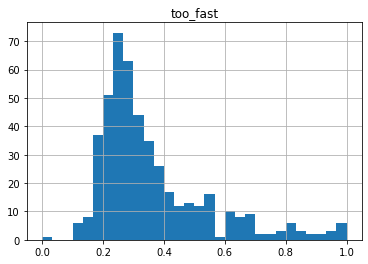

In [130]:
# прекод
data = pd.read_csv('/datasets/visits.csv', sep='\t')
data['local_time'] = pd.to_datetime(
    data['date_time'], format='%Y-%m-%dT%H:%M:%S'
) + pd.Timedelta(hours=3)
data['too_fast'] = data['time_spent'] < 60
too_fast_stat = data.pivot_table(index='id', values='too_fast')

too_fast_stat.hist(bins = 30)

Пик графика около 0,3. Значит, у большинства АЗС около 30% заездов аномально быстрые. Однако бывают и АЗС, где 100% заездов аномально быстрые. Эту проблему нужно зафиксировать и сообщить о ней коллегам, готовившим данные к анализу.

### Задача 5/5
Проблема сверхкоротких заправок зафиксирована. Проделаем то же самое с аномально долгими заправками.

Создайте столбец `data['too_slow']`, в котором будут значения:
- `True` — если время заезда более 1000 секунд;
- `False` — если время заезда менее или равно 1000 секундам.

Постройте гистограмму доли `too_slow` по разным АЗС (группируя по id). Данные для гистограммы делите на 30 корзин.
>Задача аналогична предыдущим. Сперва создайте булев массив и сохраните его в столбце `data['too_slow']`. Затем, не создавая промежуточной переменной, передайте нужные параметры последовательности `data.pivot_table().hist()`.

array([[<AxesSubplot:title={'center':'too_slow'}>]], dtype=object)

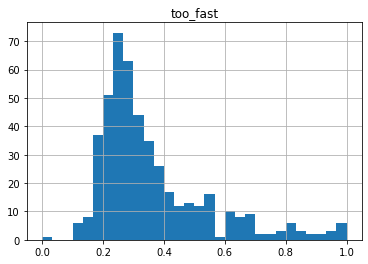

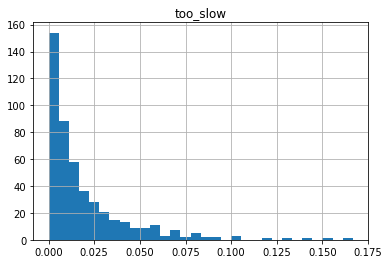

In [131]:
# прекод
data = pd.read_csv('datasets/visits.csv', sep='\t')
data['local_time'] = pd.to_datetime(
    data['date_time'], format='%Y-%m-%dT%H:%M:%S'
) + pd.Timedelta(hours=3)
data['too_fast'] = data['time_spent'] < 60
too_fast_stat = data.pivot_table(index='id', values='too_fast')
too_fast_stat.hist(bins = 30)

data['too_slow'] = data['time_spent'] > 1000
(data
.pivot_table(index='id', values='too_slow')
.hist(bins=30)
)

Слишком долгих заправок гораздо меньше, чем слишком коротких. На большинстве станций длительных заездов меньше 5%. Простимся с ними без печали.

<a name="10">_</a>
## Сохраняем результаты
Подведём итоги исследования.

Бывает, что заправляются долго. Причём повсюду. Только доля таких заправок невелика. В гистограммах заездов на АЗС с рекордно долгими заправками — ничего особенного, выглядят они ожидаемо.

Мы решили отбросить слишком долгие заезды (более 1000 секунд), а для надёжности вместо среднего арифметического времени рассчитывать медианное. Тогда эти заезды не исказят оценку типичной продолжительности заправки.

А вот с короткими заездами всё не так радужно. Их гораздо больше. Есть АЗС, где коротких заправок большинство, а то и все 100%. Что-то здесь не то.

Ошибка в исходных данных? Сформулируем проблему, чтобы упростить поиск потенциальной ошибки в алгоритме выгрузки данных. Правильное сообщение об ошибке, или **баг-репорт** (от англ. bug report, «сообщение об ошибке»), должно чётко объяснять, в чём именно ошибка и как её найти.

Мы часами исследовали данные и хорошо понимаем суть проблемы. Коллеги, отвечающие за выгрузку, ничего этого не знают. Поэтому нужно **чётко формулировать, где мы видим проблему**. Для этого не подходит описание «слишком быстрые» или «пик около 0». Нужно быть точнее.

Мы видели гистограмму и решили, что **проблемные заезды — те, что короче 60 секунд**. Это и нужно сказать.

Следует сообщить, что мы видим проблему в том, что **таких заправок слишком много** (если бы такие заезды составляли 1% от всех данных, мы бы не сочиняли баг-репорт).

Облегчим работу коллег, **сфокусируем их внимание на самой проблемной АЗС** — там будет легче отловить ошибку. Или понять, что это не ошибка, а какое-то пока неведомое явление.

Найдём эту проблемную АЗС. Напомним, что в прошлом уроке мы уже считали долю аномально быстрых заправок для каждой АЗС:

In [132]:
print(too_fast_stat.sort_values('too_fast', ascending=False).head())

          too_fast
id                
c96c61cd  1.000000
c527c306  1.000000
5372547e  1.000000
792b6ded  0.996253
bd1d0bb0  0.982044


Таких АЗС, где 100% заездов аномально быстрые, оказалось целых три! Наверное, их id нужно передать коллегам, чтобы они искали ошибку. Но сперва посмотрим сами.

Методом `describe()` оценим данные первой АЗС — `id 'c96c61cd'`:

In [133]:
data.query('id == "c96c61cd"').describe()

,time_spent
count,1.0
mean,5.0
std,NaN
min,5.0
25%,5.0
50%,5.0
75%,5.0
max,5.0


Всего 1 заезд. Это неудачный баг-репорт, ведь АЗС с одним заездом странная сама по себе. Если на ней и была какая-то проблема, не факт, что она массовая.

Для баг-репорта нужна «полноценная» АЗС с достаточным числом аномально быстрых заездов. Проверив аналогично следующие id в списке, мы обнаружили, что нормальная статистика есть только по АЗС '792b6ded':

In [134]:
data.query('id == "792b6ded"').describe()

,time_spent
count,4270.000000
mean,5.448712
std,8.597126
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,228.000000


Больше 4000 заездов, но почти все очень-очень короткие. 75% укладывается в 5 секунд. Первый квартиль составляет 2 секунды. Это значит, что как минимум 25% укладывается в 2 секунды.

Это очень удачный пример для баг-репорта. Можно передать как сам id, так и статистику по этой АЗС.

<a name="11">_</a>
## Заключение
Ура! Вы узнали, что такое срезы данных и как их строить. И да, ещё внимательнее посмотрели на АЗС: выявили зависимость продолжительности заправки от времени заезда и нашли долю аномально быстрых и долгих заправок на разных станциях. Это было непросто.

Как вы это сделали:

- Применили инструменты из первой темы: `hist()`, `boxplot()`, `describe()` — и посмотрели распределение.
- Построили графики методом `plot()`.
- Научились помечать выборку в общем объёме данных (добавив столбец 'too_fast') и смотреть, как распределен срез в совокупности данных.
- Узнали, что такое баг-репорт и как правильно формулировать проблему, чтобы упростить поиск ошибки в алгоритме выгрузки.

Теперь коллеги точно не отвертятся и обязательно поправят данные или выгрузят новые.


**Где ещё почитать про срезы данных:**

- <a href="https://www.coursera.org/lecture/mathematics-and-python/pandas-indieksatsiia-i-sieliektsiia-lsXAR">Индексация и селекция</a>
- <a href="https://devpractice.ru/pandas-indexing-part3/">Индексы и срезы по индексам</a>
- <a href="https://devpractice.ru/pandas-indexing-part3/#p6">Индексация с использованием логических выражений</a>